In [ ]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from math import sqrt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install QuantStats  PyPortfolioOpt

In [ ]:
# Importing libraries for portfolio optimization
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt import plotting
from pypfopt import objective_functions
import quantstats as qs
from pypfopt import HRPOpt

# Models

Code for calculate the maximum return

In [ ]:
## define the stocks for our portfolio (via tickers) ###
assets = [ "AMZN", "BTC-USD","GOOGL","IAU","MA","VOO","AAPL","KO","QQQ","NU","TLT","EC","LIT","BAR","CVX","CIB","HPQ","NVDA","AXP","BRK-B","VT","REM"]
#IAU iShares Gold Trust
#MA Mastercard
assets =sorted(assets)
start = "2022-01-01"
end = "2024-12-31"
# Acquire data
df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices = df_prices.dropna()
# We transform the data to its logarithmic returns
df = np.log(df_prices).diff()
# Drop the first row because we loose information we the logarithmic return.
df = df.dropna()  # this is a dataframe

# Compute the Expected Returns, we multiply daily return by 252
#because there are 252 business days in the US.
exp_returns = df.mean()*252
# compute the covariance matrix
cova = df.cov()*252
#number of assets
m=exp_returns.shape[0]


[*********************100%%**********************]  22 of 22 completed


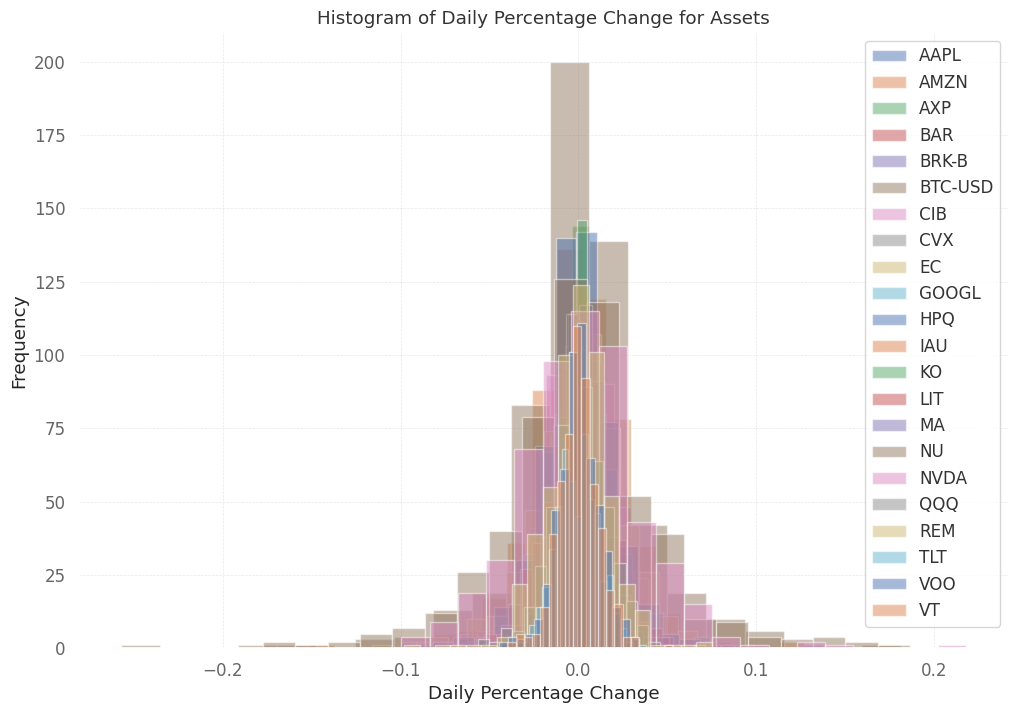

In [ ]:
# Plot histograms for each asset
plt.figure(figsize=(12, 8))
for asset in assets:
    plt.hist(df[asset], bins=20, alpha=0.5, label=asset)

plt.title('Histogram of Daily Percentage Change for Assets')
plt.xlabel('Daily Percentage Change')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

<Figure size 1000x600 with 0 Axes>

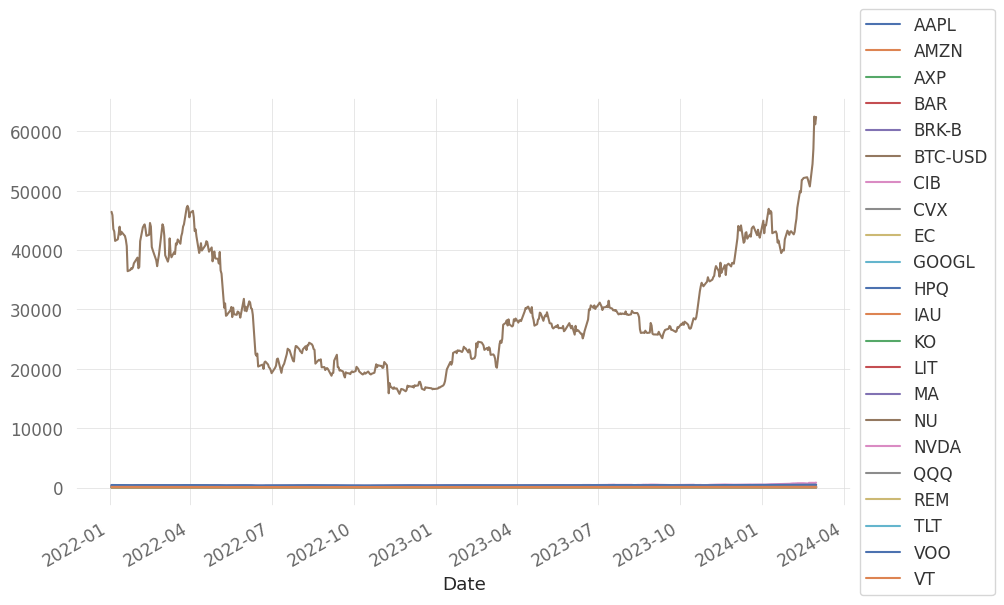

In [ ]:
#plot assets prices
plt.figure()
df_prices.plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

<Figure size 1000x600 with 0 Axes>

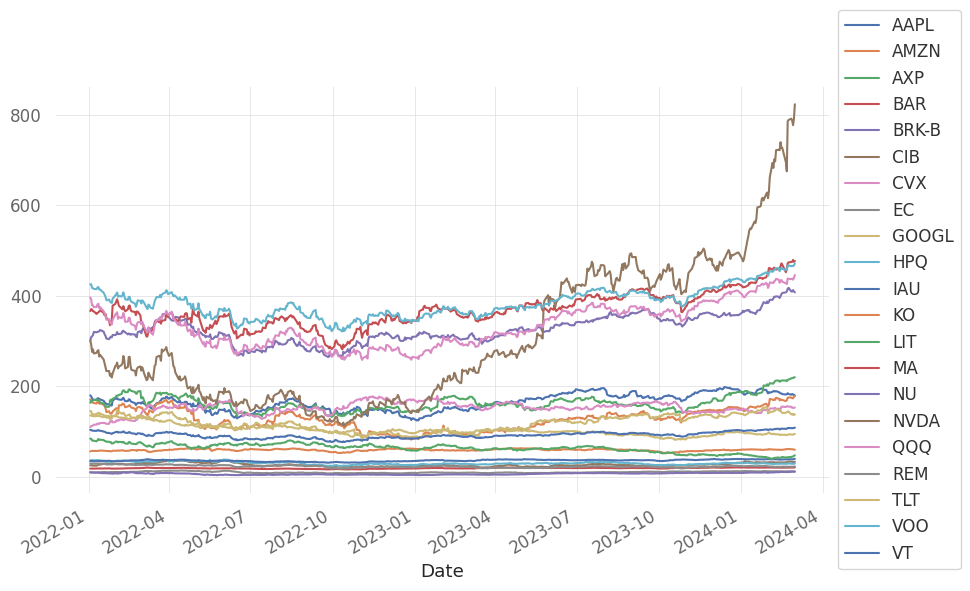

In [ ]:
#plot assets prices
plt.figure()
df_prices.drop(columns='BTC-USD').plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

<Figure size 1000x600 with 0 Axes>

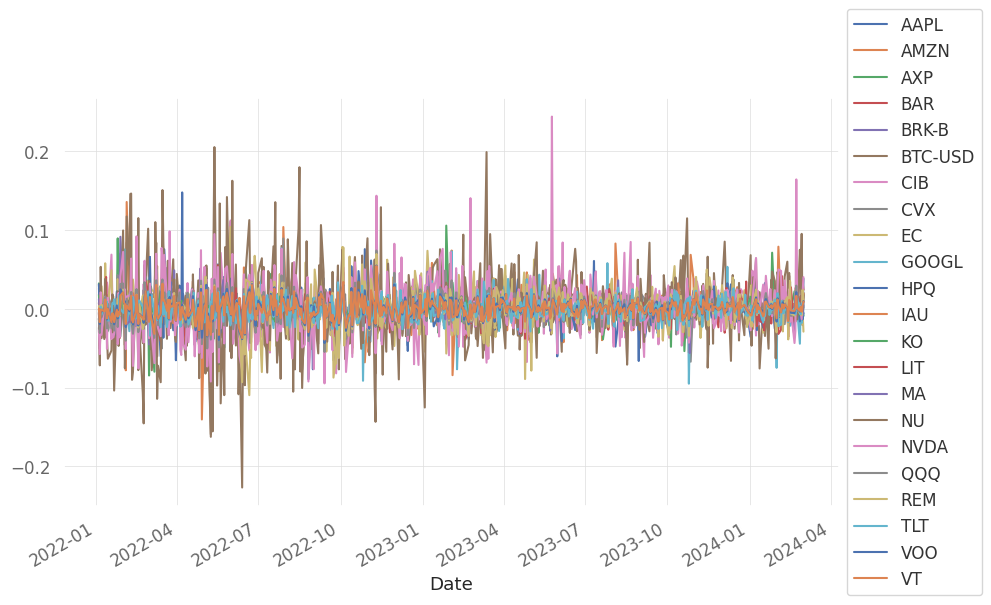

In [ ]:
plt.figure()
df_prices.pct_change().plot()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

In [ ]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 543 entries, 2022-01-03 to 2024-03-01
Data columns (total 22 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AAPL     543 non-null    float64
 1   AMZN     543 non-null    float64
 2   AXP      543 non-null    float64
 3   BAR      543 non-null    float64
 4   BRK-B    543 non-null    float64
 5   BTC-USD  543 non-null    float64
 6   CIB      543 non-null    float64
 7   CVX      543 non-null    float64
 8   EC       543 non-null    float64
 9   GOOGL    543 non-null    float64
 10  HPQ      543 non-null    float64
 11  IAU      543 non-null    float64
 12  KO       543 non-null    float64
 13  LIT      543 non-null    float64
 14  MA       543 non-null    float64
 15  NU       543 non-null    float64
 16  NVDA     543 non-null    float64
 17  QQQ      543 non-null    float64
 18  REM      543 non-null    float64
 19  TLT      543 non-null    float64
 20  VOO      543 non-null    float64
 2

In [ ]:
#covariance calculation
df_prices.pct_change().dropna().cov()

Ticker,AAPL,AMZN,AXP,BAR,BRK-B,BTC-USD,CIB,CVX,EC,GOOGL,...,KO,LIT,MA,NU,NVDA,QQQ,REM,TLT,VOO,VT
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000320,0.000288,0.000189,0.000012,1.222354e-04,0.000231,0.000102,0.000074,9.273598e-05,0.000271,...,0.000078,0.000176,0.000193,0.000311,0.000410,0.000247,0.000170,1.734225e-05,0.000179,0.000160
AMZN,0.000288,0.000690,0.000243,0.000027,1.416256e-04,0.000364,0.000127,0.000080,1.049349e-04,0.000384,...,0.000071,0.000249,0.000220,0.000482,0.000560,0.000338,0.000221,3.564511e-05,0.000233,0.000211
AXP,0.000189,0.000243,0.000371,0.000004,1.436757e-04,0.000208,0.000154,0.000093,1.359510e-04,0.000186,...,0.000071,0.000190,0.000188,0.000298,0.000342,0.000193,0.000205,5.040778e-06,0.000162,0.000156
BAR,0.000012,0.000027,0.000004,0.000078,1.144158e-05,0.000036,0.000044,0.000034,6.323481e-05,0.000014,...,0.000011,0.000036,0.000010,0.000024,0.000017,0.000015,0.000032,3.959450e-05,0.000014,0.000021
BRK-B,0.000122,0.000142,0.000144,0.000011,1.330314e-04,0.000110,0.000097,0.000087,1.070484e-04,0.000129,...,0.000065,0.000089,0.000112,0.000142,0.000184,0.000117,0.000116,2.503445e-07,0.000106,0.000097
BTC-USD,0.000231,0.000364,0.000208,0.000036,1.100564e-04,0.001259,0.000144,0.000097,1.489809e-04,0.000252,...,0.000051,0.000258,0.000189,0.000452,0.000477,0.000253,0.000198,2.131441e-05,0.000182,0.000178
CIB,0.000102,0.000127,0.000154,0.000044,9.720317e-05,0.000144,0.000508,0.000135,3.526208e-04,0.000100,...,0.000050,0.000145,0.000110,0.000174,0.000175,0.000102,0.000161,3.123944e-05,0.000099,0.000110
CVX,0.000074,0.000080,0.000093,0.000034,8.737488e-05,0.000097,0.000135,0.000310,2.791583e-04,0.000064,...,0.000030,0.000098,0.000060,0.000102,0.000095,0.000068,0.000118,-1.462610e-05,0.000078,0.000079
EC,0.000093,0.000105,0.000136,0.000063,1.070484e-04,0.000149,0.000353,0.000279,6.675418e-04,0.000074,...,0.000038,0.000157,0.000093,0.000129,0.000109,0.000082,0.000159,4.949581e-07,0.000094,0.000104


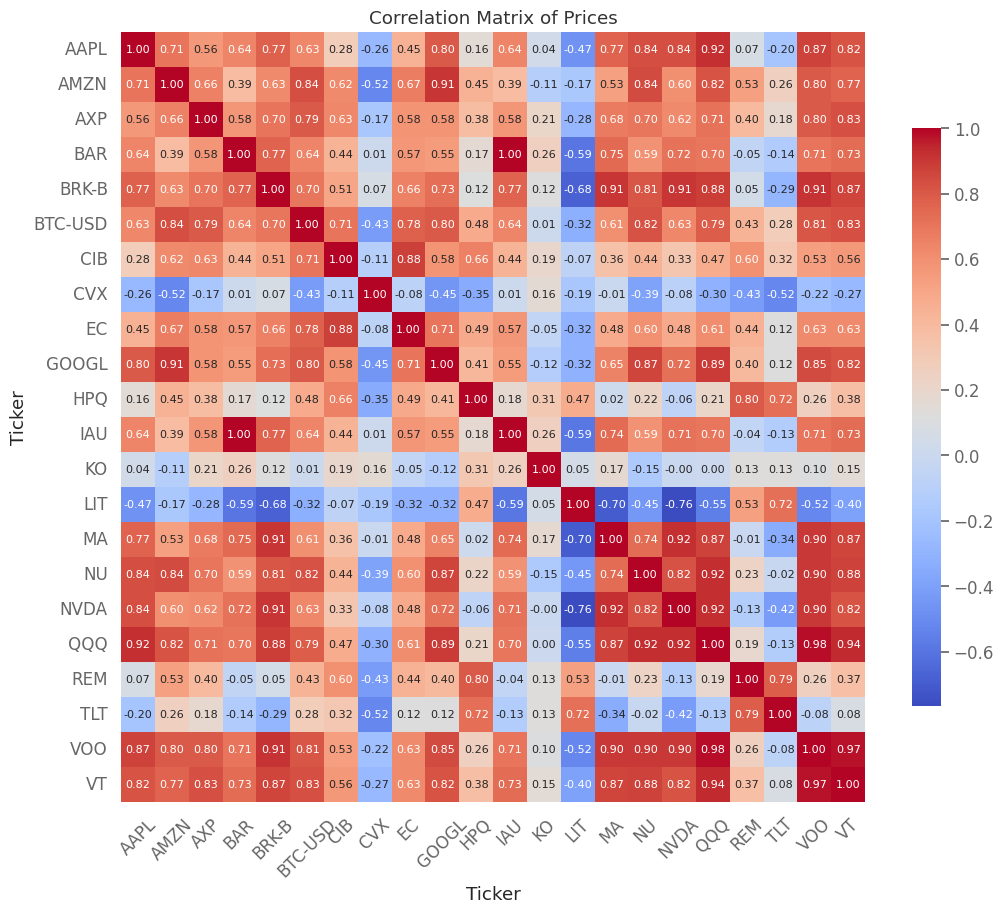

In [ ]:
# Compute correlation matrix
correlation_matrix = df_prices.corr()

# Increase figure size
plt.figure(figsize=(12, 10))

# Generate a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8}, cbar_kws={"shrink": .75})
plt.title('Correlation Matrix of Prices')

# Rotate tick labels
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()

In [ ]:
len(assets)

22

## Markovitz

In [ ]:
df=df_prices
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()
#print("expected returns", mu)
#print("estimated covariance matrix",S)

In [ ]:
ef = EfficientFrontier(mu, S)
ef.add_constraint(lambda x : x <= 0.15)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
markowitz_weights = ef.max_sharpe()

In [ ]:
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('AXP', 0.0758), ('BAR', 0.14347), ('BRK-B', 0.15), ('BTC-USD', 0.01284), ('CIB', 0.06317), ('CVX', 0.15), ('EC', 0.0), ('GOOGL', 0.0), ('HPQ', 0.0), ('IAU', 0.14065), ('KO', 0.02773), ('LIT', 0.0), ('MA', 0.08634), ('NU', 0.0), ('NVDA', 0.15), ('QQQ', 0.0), ('REM', 0.0), ('TLT', 0.0), ('VOO', 0.0), ('VT', 0.0)])


## Black litterman allocation

In [ ]:
market_cap_data = {}

# Loop through assets and fetch market cap
for asset in assets:
    try:
        ticker = yf.Ticker(asset)
        info = ticker.info
        market_cap_data[asset] = info['marketCap']
    except Exception as e:
        print(f"Error fetching data for {asset}: {e}")

# Convert the dictionary to a pandas Series
market_cap_series = pd.Series(market_cap_data, name='marketCap')

# Print the market cap series
print(market_cap_series)

Error fetching data for BAR: 'marketCap'
Error fetching data for IAU: 'marketCap'
Error fetching data for LIT: 'marketCap'
Error fetching data for QQQ: 'marketCap'
Error fetching data for REM: 'marketCap'
Error fetching data for TLT: 'marketCap'
Error fetching data for VOO: 'marketCap'
Error fetching data for VT: 'marketCap'
AAPL       2703876685824
AMZN       1844594475008
AXP         158462394368
BRK-B       873472458752
BTC-USD    1346278785024
CIB           7862666752
CVX         276510375936
EC           22141290496
GOOGL      1663127912448
HPQ          28434657280
KO          257928232960
MA          437050572800
NU           53092577280
NVDA       2130924929024
Name: marketCap, dtype: int64


In [ ]:
market_cap_data = {
    "AAPL":       2790737313792,
    "AMZN":       1800292139008,
    "AXP":         157749379072,
    "BRK-B":       892726149120,
    "BTC-USD":    1196721176576,
    "CIB":           8007493632,
    "CVX":         282314342400,
    "EC":           24212019200,
    "GOOGL":      1697544011776,
    "HPQ":          28165576704,
    "KO":          259825696768,
    "MA":          445269344256,
    "NU":           52660629504,
    "NVDA":       1954325987328,
    "BAR":         282314342400,
    "IAU":          92780000000,
    "LIT":             48410000,
    "QQQ":         171160000000,
    "REM":            617500000,
    "TLT":          11740000000,
    "VOO":         208200000000,
    "VT":           78700000000
}

# Convert the dictionary to a pandas Series
market_cap_series = pd.Series(market_cap_data, name='marketCap')
market_cap_series=market_cap_series.sort_index()
# Print the market cap series
print(market_cap_series)

AAPL       2790737313792
AMZN       1800292139008
AXP         157749379072
BAR         282314342400
BRK-B       892726149120
BTC-USD    1196721176576
CIB           8007493632
CVX         282314342400
EC           24212019200
GOOGL      1697544011776
HPQ          28165576704
IAU          92780000000
KO          259825696768
LIT             48410000
MA          445269344256
NU           52660629504
NVDA       1954325987328
QQQ         171160000000
REM            617500000
TLT          11740000000
VOO         208200000000
VT           78700000000
Name: marketCap, dtype: int64


In [ ]:
# Calculating the annualized expected returns and the annualized sample covariance matrix
mu = expected_returns.mean_historical_return(df_prices) #expected returns
S = risk_models.sample_cov(df_prices) #Covariance matrix
S = pd.DataFrame(S).to_numpy()
S

array([[ 8.07328110e-02,  7.26156950e-02,  4.77233839e-02,
         3.09941703e-03,  3.08033140e-02,  5.81059594e-02,
         2.58009564e-02,  1.85946130e-02,  2.33694666e-02,
         6.82070482e-02,  5.42027302e-02,  3.46587910e-03,
         1.96400457e-02,  4.43230375e-02,  4.85651430e-02,
         7.84445179e-02,  1.03354478e-01,  6.23437393e-02,
         4.27270895e-02,  4.37024590e-03,  4.51988381e-02,
         4.02307292e-02],
       [ 7.26156950e-02,  1.73977782e-01,  6.13130918e-02,
         6.87708180e-03,  3.56896596e-02,  9.17165830e-02,
         3.20981842e-02,  2.00379068e-02,  2.64435970e-02,
         9.66476879e-02,  6.30708222e-02,  7.22087626e-03,
         1.78941526e-02,  6.26541908e-02,  5.54917857e-02,
         1.21509055e-01,  1.41018550e-01,  8.52235656e-02,
         5.56470629e-02,  8.98256652e-03,  5.86657848e-02,
         5.31998456e-02],
       [ 4.77233839e-02,  6.13130918e-02,  9.34983368e-02,
         9.32958661e-04,  3.62062829e-02,  5.22913876e-02,
    

In [ ]:
market_prices = yf.download("^GSPC",start = start,
                            end = end)['Adj Close']
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta # Visualizing delta

[*********************100%%**********************]  1 of 1 completed


0.8124695862534481

In [ ]:
# Obtaining Prior estimates
prior = black_litterman.market_implied_prior_returns(market_cap_series,
                                                     delta, S)
prior # Visualizing prior estimates

array([0.07496344, 0.09739456, 0.06312636, 0.02417441, 0.0464677 ,
       0.09518186, 0.04468626, 0.0370976 , 0.0415417 , 0.08376383,
       0.06737365, 0.02440851, 0.03356887, 0.06332266, 0.06093276,
       0.09811318, 0.12926829, 0.07569291, 0.0579243 , 0.02421623,
       0.05965122, 0.05632912])

In [ ]:
# Inputtig values for vector Q
Q = np.array([0.27,   # AMZN retorn 54% revisado beto
              0.12,   # AMX will raise by 22%
              0.11])  # MA will raise by 21% valor revisado con beto
# AMZN        BTC-USD      GOOGL       IAU       MA

In [ ]:
assets

['AAPL',
 'AMZN',
 'AXP',
 'BAR',
 'BRK-B',
 'BTC-USD',
 'CIB',
 'CVX',
 'EC',
 'GOOGL',
 'HPQ',
 'IAU',
 'KO',
 'LIT',
 'MA',
 'NU',
 'NVDA',
 'QQQ',
 'REM',
 'TLT',
 'VOO',
 'VT']

In [ ]:
# Number of views (m) and number of assets (n)
m = 3  # Number of views
n = len(assets)  # Number of assets

# Define the views linking to assets
P = np.zeros((m, n))

# Define the views and assets preferences
# Example: Each row corresponds to a view, and each column corresponds to an asset
# Modify the values as per your preferences
P[0, 0] = 1  # First view expresses a preference for the first asset # AMZN = 0.056
P[1, 2] = 1  # Second view expresses a preference for the third asset # AMX = 0.024
P[2, 15] = 1  # Third view expresses a preference for the fifth asset  # MA =0.041

print("P Matrix:")
print(P)

P Matrix:
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [ ]:
# Providing confidence levels
# Closer to 0.0 = Low confidence
# Closer to 1.0 = High confidence
confidences = [0.5,
               0.5,
               0.5]

In [ ]:
# Creating model
bl = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences

rets = bl.bl_returns() # Calculating Expected returns
ef = EfficientFrontier(rets, S) # Optimizing asset allocation
ef.add_constraint(lambda x : x <= 0.15)
ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
weights_BL = ef.clean_weights() # Cleaning weights
weights_BL # Printing weights

OrderedDict([(0, 0.15),
             (1, 0.01655),
             (2, 0.00319),
             (3, 0.0),
             (4, 0.05271),
             (5, 0.03122),
             (6, 0.0),
             (7, 0.01072),
             (8, 0.0),
             (9, 0.11442),
             (10, 0.0222),
             (11, 0.05403),
             (12, 0.09596),
             (13, 0.0),
             (14, 0.0741),
             (15, 0.0),
             (16, 0.04323),
             (17, 0.15),
             (18, 0.0),
             (19, 0.0317),
             (20, 0.15),
             (21, 0.0)])

In [ ]:
expected_return, volatility, sharpe_ratio=ef.portfolio_performance(verbose=False, risk_free_rate=0.02)
print('Expected return', expected_return)
print('volatility', volatility)
print('Sharpe ratio', sharpe_ratio)

Expected return 0.12593874762961002
volatility 0.20667256424925753
Sharpe ratio 0.512592215683948


In [ ]:
BL_model_weight= [weights_BL[i] for i in weights_BL]
markowitz_weights = [markowitz_weights[i] for i in markowitz_weights]

In [ ]:
n_assets = len(assets)
n_strategy_weights = np.array([1/n_assets for _ in range(n_assets)])

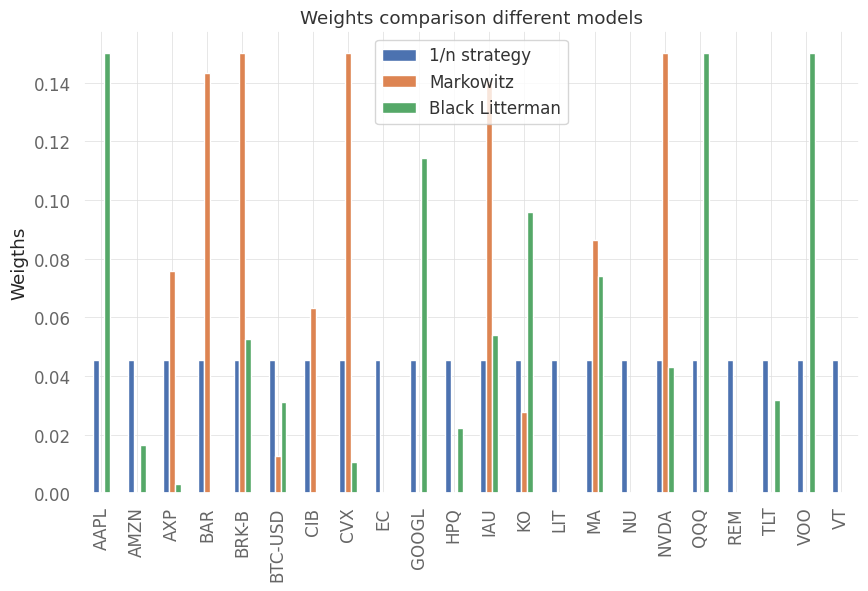

In [ ]:
df=pd.DataFrame({'1/n strategy': n_strategy_weights,
                   'Markowitz': markowitz_weights,
                'Black Litterman': BL_model_weight}, index=assets)
df.plot(kind="bar", title='Weights comparison different models',ylabel='Weigths');

In [ ]:
df*100

,1/n strategy,Markowitz,Black Litterman
AAPL,4.545455,0.000000,15.000
AMZN,4.545455,0.000000,1.655
AXP,4.545455,7.580328,0.319
BAR,4.545455,14.346734,0.000
BRK-B,4.545455,15.000000,5.271
BTC-USD,4.545455,1.284484,3.122
CIB,4.545455,6.317482,0.000
CVX,4.545455,15.000000,1.072
EC,4.545455,0.000000,0.000
GOOGL,4.545455,0.000000,11.442


In [ ]:

#ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
#ef.add_constraint(lambda w: w[0] >= 0.2)
#ef.add_constraint(lambda w: w[2] == 0.15)
#ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

#fig, ax = plt.subplots()
#plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
#plt.show()

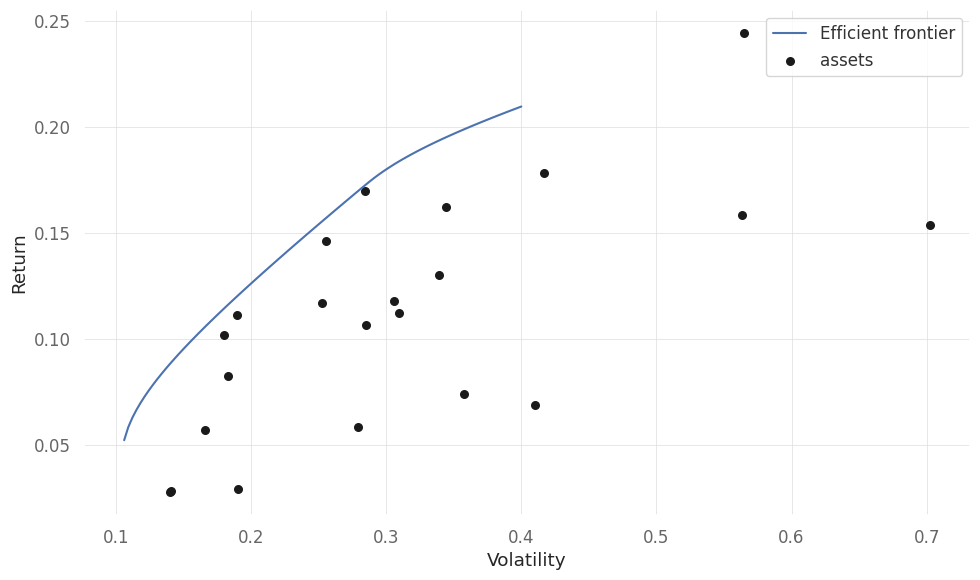

<Axes: xlabel='Volatility', ylabel='Return'>

In [ ]:
# Create a new EfficientFrontier instance with the same parameters as 'ef'
ef_new = EfficientFrontier(ef.expected_returns, ef.cov_matrix)

# 100 portfolios with risks between 0.10 and 0.30
risk_range = np.linspace(0.10, 0.40, 100)
plotting.plot_efficient_frontier(ef_new, ef_param="risk", ef_param_range=risk_range,
                                show_assets=True, showfig=True)

In [ ]:
#fig, ax = plt.subplots()
#ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
#ef_max_sharpe = ef.deepcopy()
#plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False, verbose=True)

# Find the tangency portfolio
#ef_max_sharpe.max_sharpe()
#ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
#ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
#n_samples = 10000
#w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
#rets = w.dot(ef.expected_returns)
#stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
#sharpes = rets / stds
#ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
#ax.set_title("Efficient Frontier with random portfolios")
#ax.legend()
#plt.tight_layout()
#plt.savefig("ef_scatter.png", dpi=200)
#plt.show()

In [ ]:
df['Black Litterman']

AAPL       0.15000
AMZN       0.01655
AXP        0.00319
BAR        0.00000
BRK-B      0.05271
BTC-USD    0.03122
CIB        0.00000
CVX        0.01072
EC         0.00000
GOOGL      0.11442
HPQ        0.02220
IAU        0.05403
KO         0.09596
LIT        0.00000
MA         0.07410
NU         0.00000
NVDA       0.04323
QQQ        0.15000
REM        0.00000
TLT        0.03170
VOO        0.15000
VT         0.00000
Name: Black Litterman, dtype: float64

In [ ]:
# Specify the Column Names while initializing the Table
#myTable = PrettyTable(["Item",  "SciPy optimizer", "1/n stategy", "Black litterman"])

# Add rows
#myTable.add_row(["Return", round(get_ret_vol_sr(optimal_weights)[0],3),round(get_ret_vol_sr(n_strategy_weights)[0],3),round(get_ret_vol_sr(BL_model_weight)[0],3)])
#myTable.add_row(["Volatility", round(get_ret_vol_sr(optimal_weights)[1],3),round(get_ret_vol_sr(n_strategy_weights)[1],3),round(get_ret_vol_sr(BL_model_weight)[1],3)])
#myTable.add_row(["Sharpe Ratio", round(get_ret_vol_sr(optimal_weights)[2],3),round(get_ret_vol_sr(n_strategy_weights)[2],3),round(get_ret_vol_sr(BL_model_weight)[2],3)])

#print(myTable)

In [ ]:
Total_invest=1_000
# Initialize an array to store the product of each asset price and its weight
portfolio= np.zeros(len(df_prices))
# Loop through each asset and its weight, and calculate the contribution to the portfolio
for i in range(n):
    asset_name = assets[i]  # Assuming asset names are 'Asset_0', 'Asset_1', ..., 'Asset_(n-1)'
    asset_price = df_prices[asset_name]/df_prices[asset_name][0]
    asset_weight = BL_model_weight[i]
    portfolio += asset_price * asset_weight
portfolio= portfolio * Total_invest
# Calculate the total portfolio value
portfolio_value = np.sum(portfolio)
market_prices=market_prices/market_prices[0]*Total_invest
# Print the portfolio value
print("Portfolio Value:", portfolio_value)

Portfolio Value: 498619.12783334224


[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-01-05   2022-01-05
End Period                 2024-03-01   2024-03-01
Risk-Free Rate             0.0%         0.0%
Time in Market             20.0%        100.0%

Cumulative Return          -100.0%      16.41%
CAGR﹪                     -100.0%      4.99%

Sharpe                     -0.77        0.46
Prob. Sharpe Ratio         0.72%        74.78%
Smart Sharpe               -0.77        0.46
Sortino                    -0.78        0.66
Smart Sortino              -0.77        0.65
Sortino/√2                 -0.55        0.46
Smart Sortino/√2           -0.55        0.46
Omega                      1.08         1.08

Max Drawdown               -100.0%      -25.73%
Longest DD Days            779          470
Volatility (ann.)          69.04%       19.8%
R^2                        0.02         0.02
Information Ratio          0.06         0.0

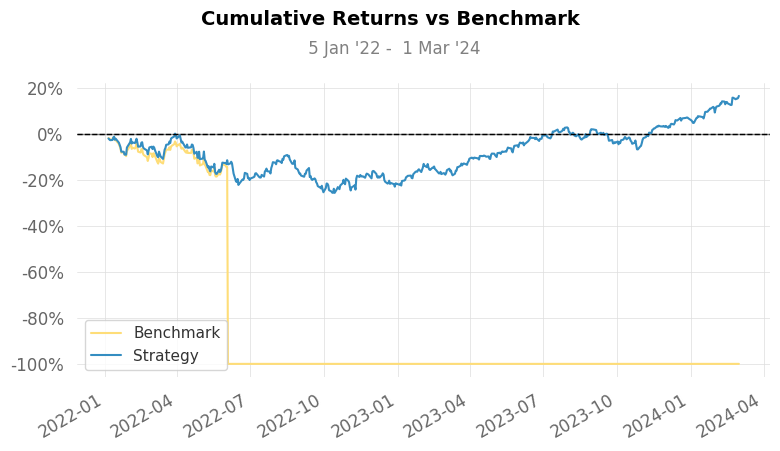

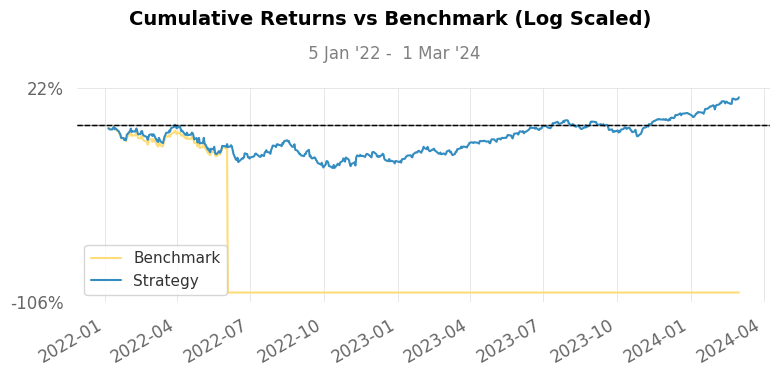

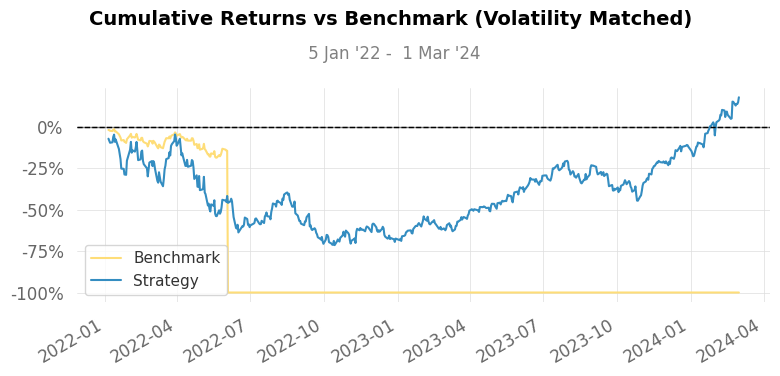

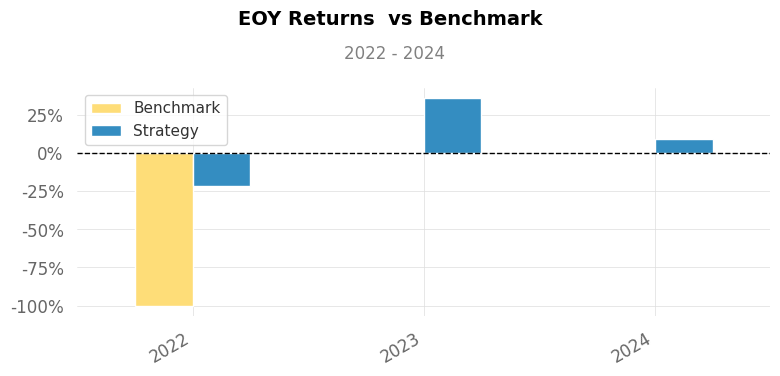

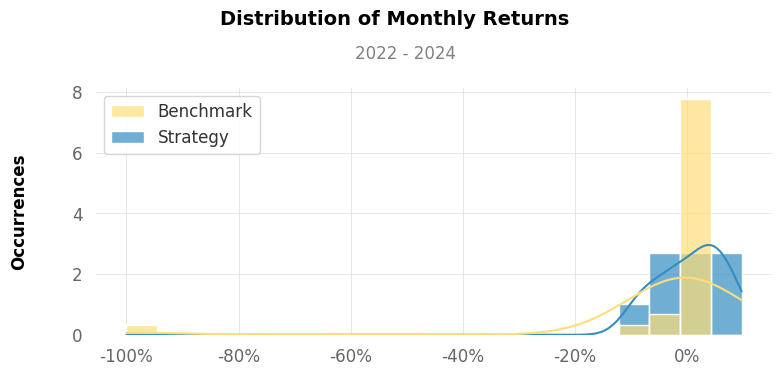

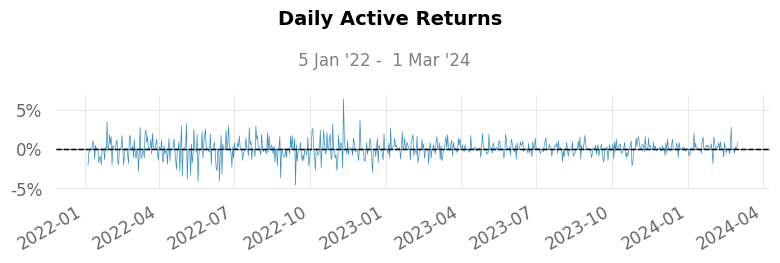

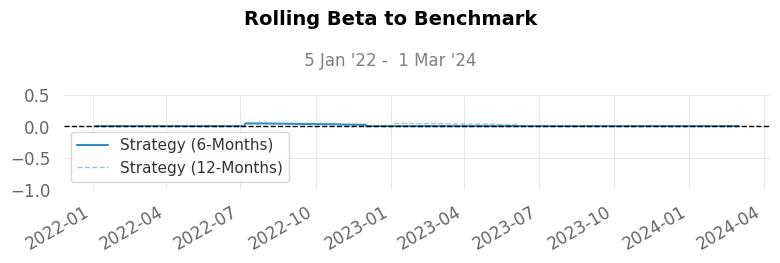

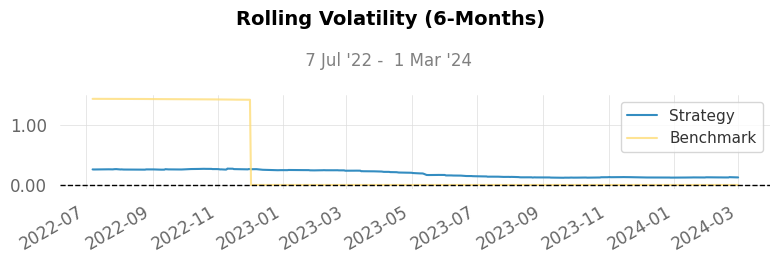

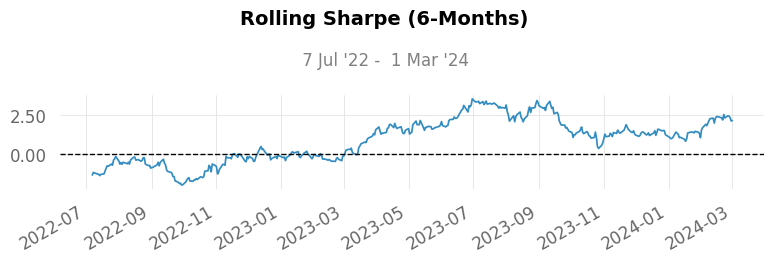

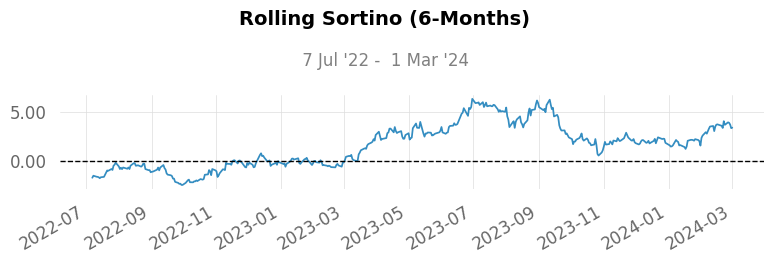

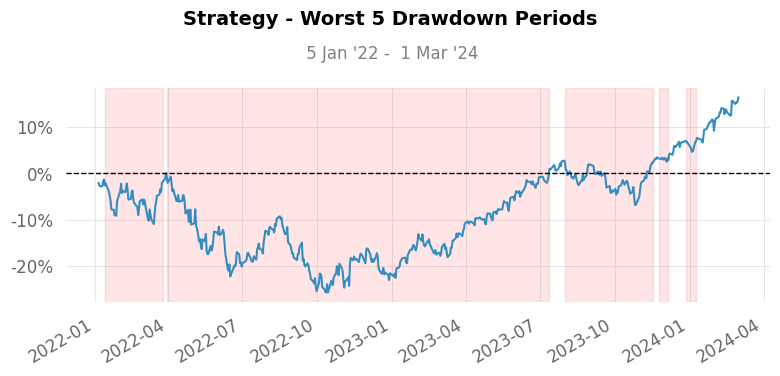

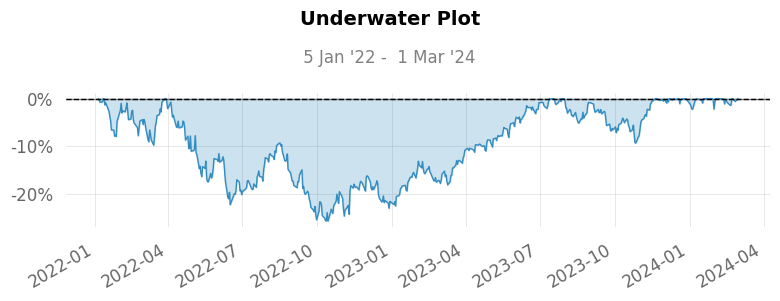

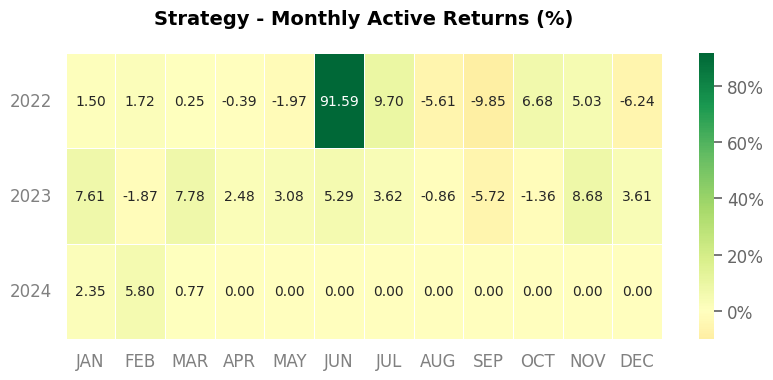

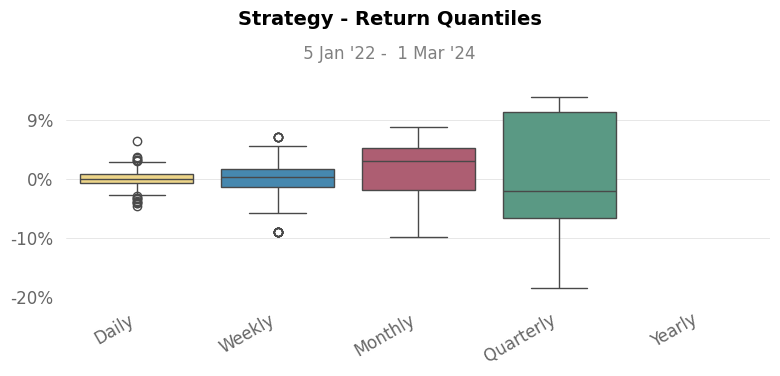

In [ ]:
qs.reports.full(portfolio, benchmark = market_prices)

## Hierarchical Risk Parity (HRP)

In [ ]:
rets = expected_returns.returns_from_prices(df_prices)
rets.tail()

Ticker,AAPL,AMZN,AXP,BAR,BRK-B,BTC-USD,CIB,CVX,EC,GOOGL,...,KO,LIT,MA,NU,NVDA,QQQ,REM,TLT,VOO,VT
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-26,-0.007451,-0.001486,0.011186,-0.002484,-0.019366,0.074715,-0.002708,-0.001358,0.006780,-0.044387,...,-0.008007,0.011852,0.002302,0.048924,0.003489,-0.000527,-0.006341,-0.002983,-0.003663,-0.002604
2024-02-27,0.008114,-0.006811,0.004701,-0.000996,-0.000562,0.047008,-0.016295,-0.014827,0.008417,0.009522,...,-0.006095,0.016307,0.000506,0.039179,-0.004944,0.002405,0.002735,-0.007052,0.001849,0.002145
2024-02-28,-0.006625,-0.002190,0.000229,0.001994,0.007899,0.094935,-0.001840,0.001183,-0.019199,-0.018001,...,0.000994,0.004972,0.008636,-0.006284,-0.013189,-0.005325,-0.008182,0.006349,-0.001545,-0.003815
2024-02-29,-0.003693,0.020790,0.006375,0.005473,-0.006648,-0.020901,-0.000615,-0.002166,-0.004255,0.015252,...,-0.006291,0.035754,-0.008541,0.000903,0.018658,0.008569,0.023831,0.007057,0.003697,0.004110
2024-03-01,-0.006030,0.008260,0.001094,0.018803,-0.005594,0.020299,0.007380,0.005263,-0.029060,-0.009533,...,-0.008164,0.023882,0.003939,0.017148,0.040032,0.015057,0.008953,0.006231,0.009637,0.008930


In [ ]:
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('AAPL', 0.01895),
             ('AMZN', 0.01556),
             ('AXP', 0.02193),
             ('BAR', 0.11627),
             ('BRK-B', 0.06114),
             ('BTC-USD', 0.00979),
             ('CIB', 0.02784),
             ('CVX', 0.04562),
             ('EC', 0.02364),
             ('GOOGL', 0.0196),
             ('HPQ', 0.01786),
             ('IAU', 0.11493),
             ('KO', 0.11037),
             ('LIT', 0.03229),
             ('MA', 0.04242),
             ('NU', 0.00629),
             ('NVDA', 0.0048),
             ('QQQ', 0.05447),
             ('REM', 0.02521),
             ('TLT', 0.12564),
             ('VOO', 0.0499),
             ('VT', 0.0555)])

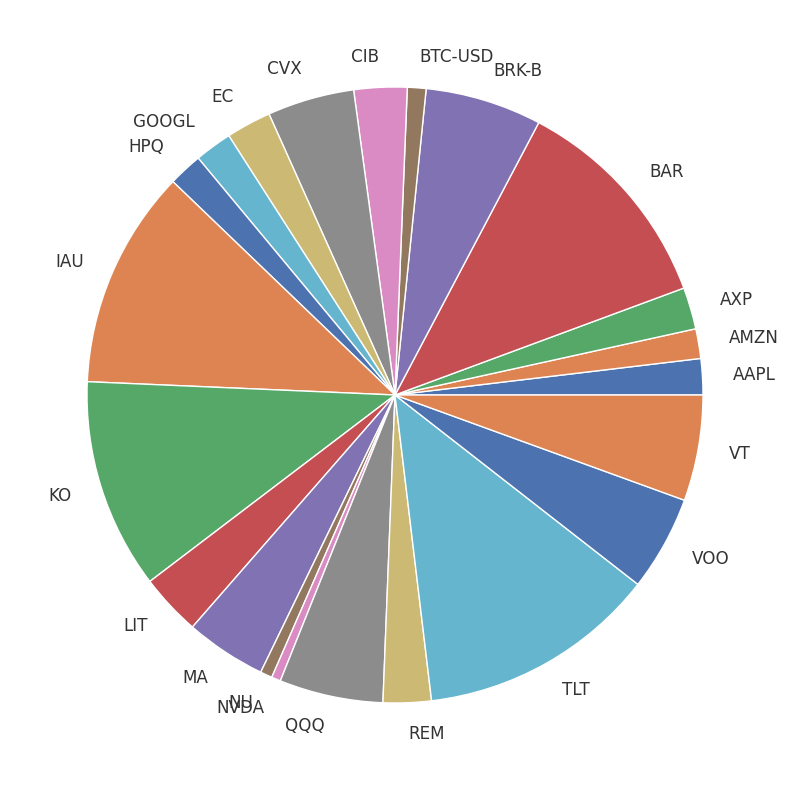

In [ ]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [ ]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 5.3%
Annual volatility: 13.3%
Sharpe Ratio: 0.25


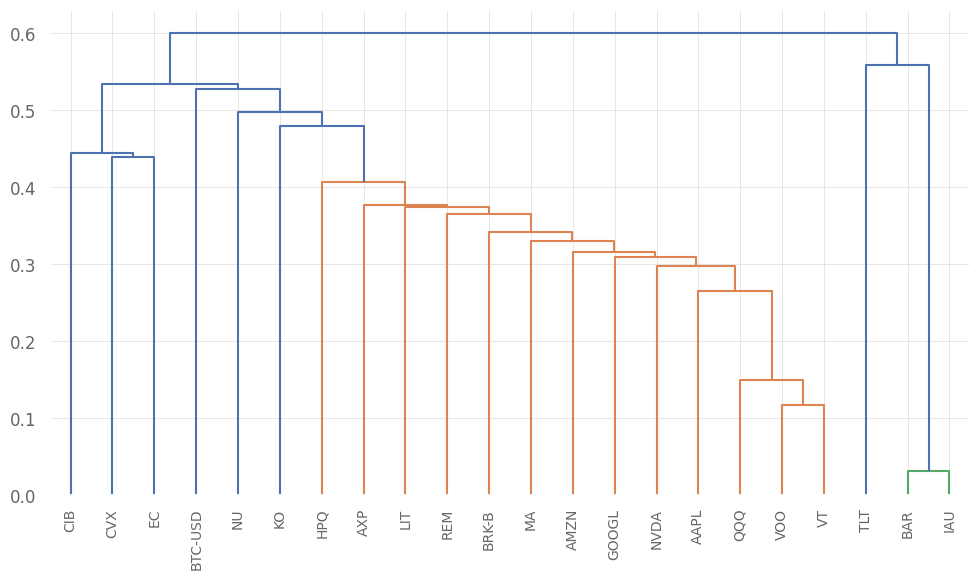

In [ ]:
plotting.plot_dendrogram(hrp);

In [ ]:
hrp_weights = [weights[i] for i in weights]

## earnings per asset

In [ ]:
earnings = []
for a in assets:
    initial = df_prices[a][0]
    final = df_prices[a][-1]
    earning = (final - initial) / initial * 100
    earnings.append((a,initial,final, earning))

# Convert the earnings list to a DataFrame for easier manipulation and visualization
earnings_df = pd.DataFrame(earnings, columns=['Asset','Initial price','Final price', 'Earnings %'])
earnings_df=earnings_df.sort_values(by='Asset')
print(earnings_df)

      Asset  Initial price   Final price  Earnings %
0      AAPL     179.724533    179.660004   -0.035905
1      AMZN     170.404495    178.220001    4.586444
2       AXP     163.109146    219.660004   34.670562
3       BAR      17.889999     20.590000   15.092235
4     BRK-B     300.790009    407.109985   35.346911
5   BTC-USD   46458.117188  62440.632812   34.401987
6       CIB      25.322731     32.759998   29.369926
7       CVX     109.565926    152.809998   39.468541
8        EC       9.304106     11.360000   22.096631
9     GOOGL     144.991501    137.139999   -5.415146
10      HPQ      35.545994     29.410000  -17.262125
11      IAU      34.259998     39.400002   15.002929
12       KO      55.834465     59.529999    6.618732
13      LIT      84.217758     47.160000  -44.002309
14       MA     365.975952    476.630005   30.235334
15       NU       9.980000     11.270000   12.925861
16     NVDA     300.795135    822.789978  173.538326
17      QQQ     396.005341    445.609985   12.

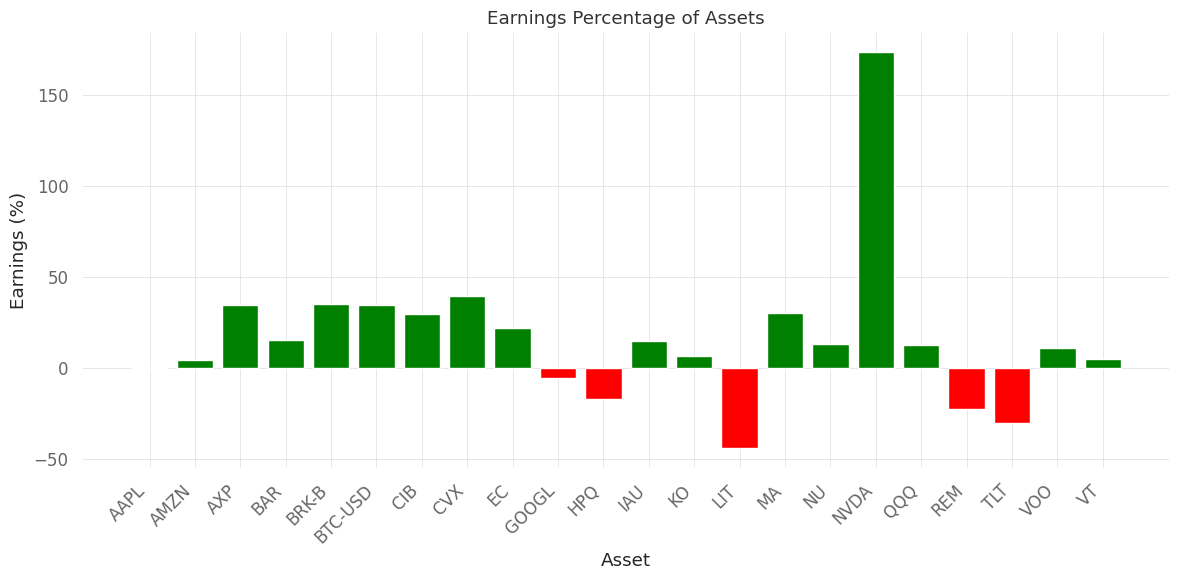

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(earnings_df['Asset'], earnings_df['Earnings %'], color=['red' if earning < 0 else 'green' for earning in earnings_df['Earnings %']])
plt.xlabel('Asset')
plt.ylabel('Earnings (%)')
plt.title('Earnings Percentage of Assets')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Benchmark 2024

In [ ]:
start = "2024-01-01"
end = "2024-02-28"
market_prices = yf.download("^GSPC",start = start,
                            end = end)['Adj Close']

df_prices = yf.download(assets,start=start,end=end)['Adj Close']
df_prices=df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  22 of 22 completed


## Strategy using black litterman

In [ ]:
Total_invest=1_000

# Initialize an array to store the product of each asset price and its weight
portfolio= np.zeros(len(df_prices))
# Loop through each asset and its weight, and calculate the contribution to the portfolio
for i in range(n):
    asset_name = assets[i]  # Assuming asset names are 'Asset_0', 'Asset_1', ..., 'Asset_(n-1)'
    asset_price = df_prices[asset_name]/df_prices[asset_name][0]
    asset_weight = BL_model_weight[i]
    portfolio += asset_price * asset_weight
bl_portfolio= portfolio * Total_invest
# Calculate the total portfolio value
portfolio_value = np.sum(portfolio)
market_prices=market_prices/market_prices[0]*Total_invest
# Print the portfolio value
print("Portfolio Value:", portfolio_value)

Portfolio Value: 41.84650941353196


## Strategy using naive strategy. Same weight all the assets

In [ ]:
Total_invest=1_000

# Initialize an array to store the product of each asset price and its weight
portfolio= np.zeros(len(df_prices))
# Loop through each asset and its weight, and calculate the contribution to the portfolio
for i in range(n):
    asset_name = assets[i]  # Assuming asset names are 'Asset_0', 'Asset_1', ..., 'Asset_(n-1)'
    asset_price = df_prices[asset_name]/df_prices[asset_name][0]
    asset_weight = 1/len(assets)
    portfolio += asset_price * asset_weight
naive_portfolio= portfolio * Total_invest
# Calculate the total portfolio value
portfolio_value = np.sum(portfolio)
# Print the portfolio value
print("Portfolio Value:", portfolio_value)

Portfolio Value: 40.194199685054635


## Using Markovitz Strategy

In [ ]:
Total_invest=1_000

# Initialize an array to store the product of each asset price and its weight
portfolio= np.zeros(len(df_prices))
# Loop through each asset and its weight, and calculate the contribution to the portfolio
for i in range(n):
    asset_name = assets[i]  # Assuming asset names are 'Asset_0', 'Asset_1', ..., 'Asset_(n-1)'
    asset_price = df_prices[asset_name]/df_prices[asset_name][0]
    asset_weight = markowitz_weights[i]
    portfolio += asset_price * asset_weight
markowitz_portfolio= portfolio * Total_invest
# Calculate the total portfolio value
portfolio_value = np.sum(portfolio)
# Print the portfolio value
print("Portfolio Value:", portfolio_value)

Portfolio Value: 39.15040732760295


## Strategy using Hierarchical Risk Parity (HRP)

In [ ]:
Total_invest=1_000

# Initialize an array to store the product of each asset price and its weight
portfolio= np.zeros(len(df_prices))
# Loop through each asset and its weight, and calculate the contribution to the portfolio
for i in range(n):
    asset_name = assets[i]  # Assuming asset names are 'Asset_0', 'Asset_1', ..., 'Asset_(n-1)'
    asset_price = df_prices[asset_name]/df_prices[asset_name][0]
    asset_weight = hrp_weights[i]
    portfolio += asset_price * asset_weight
hrp_portfolio= portfolio * Total_invest
# Calculate the total portfolio value
portfolio_value = np.sum(portfolio)
# Print the portfolio value
print("Portfolio Value:", portfolio_value)

Portfolio Value: 39.77509798692408


In [ ]:
assets

['AMZN',
 'BTC-USD',
 'GOOGL',
 'IAU',
 'MA',
 'VOO',
 'AAPL',
 'KO',
 'QQQ',
 'NU',
 'TLT',
 'EC',
 'LIT',
 'BAR',
 'CVX',
 'CIB',
 'HPQ',
 'NVDA',
 'AXP',
 'BRK-B',
 'VT',
 'REM']

## Strategy using Beto data

In [ ]:
beto_prices= [
 110.82,
 109.36,
 87.22,
 0,
 58.63,
 232.14,
 12.48,
 5.89,
 32.38,
 104.65,
 6.13,
 167.47,
 64.19,
 23.8,
 103.20,
 56.30,
 11.44,
 79.94,
 0,
 0,
 315.95,
 0]

In [ ]:
# Convert the list to a numpy array
beto_prices_array = np.array(beto_prices)

# Calculate the sum of the array
total = np.sum(beto_prices_array)

# Perform element-wise division
beto_weights = beto_prices_array / total

In [ ]:
Total_invest=1_000

# Initialize an array to store the product of each asset price and its weight
portfolio= np.zeros(len(df_prices))
# Loop through each asset and its weight, and calculate the contribution to the portfolio
for i in range(n):
    asset_name = assets[i]  # Assuming asset names are 'Asset_0', 'Asset_1', ..., 'Asset_(n-1)'
    asset_price = df_prices[asset_name]/df_prices[asset_name][0]
    asset_weight = beto_weights[i]
    portfolio += asset_price * asset_weight
beto_portfolio= portfolio * Total_invest
# Calculate the total portfolio value
portfolio_value = np.sum(portfolio)
# Print the portfolio value
print("Portfolio Value:", portfolio_value)

Portfolio Value: 40.65146955805019


## Plotting

In [ ]:
SP500_earnings = (market_prices[-1]-market_prices[0])/market_prices[0]
print("Earning % S&P500:", SP500_earnings*100)
BL_earnings=(bl_portfolio[-1]-bl_portfolio[0])/bl_portfolio[0]
print("Earning % Black literman portfolio:", BL_earnings*100)
naive_portfolio
naive_earnings=(naive_portfolio[-1]-naive_portfolio[0])/naive_portfolio[0]
print("Earning % Naive portfolio:", naive_earnings*100)
markowitz_earnings=(markowitz_portfolio[-1]-markowitz_portfolio[0])/markowitz_portfolio[0]
print("Earning % Markowitz portfolio:", markowitz_earnings*100)
hrp_earnings=(hrp_portfolio[-1]-hrp_portfolio[0])/hrp_portfolio[0]
print("Earning % Hierarchical Risk Parity (HRP) portfolio:", hrp_earnings*100)
beto_earnings=(beto_portfolio[-1]-beto_portfolio[0])/beto_portfolio[0]
print("Earning % Beto portfolio:", beto_earnings*100)

Earning % S&P500: 7.070674937374634
Earning % Black literman portfolio: 17.483979624969447
Earning % Naive portfolio: 8.357425547391736
Earning % Markowitz portfolio: 1.3147122846898693
Earning % Hierarchical Risk Parity (HRP) portfolio: 6.422082244801898
Earning % Beto portfolio: 11.246690217903769


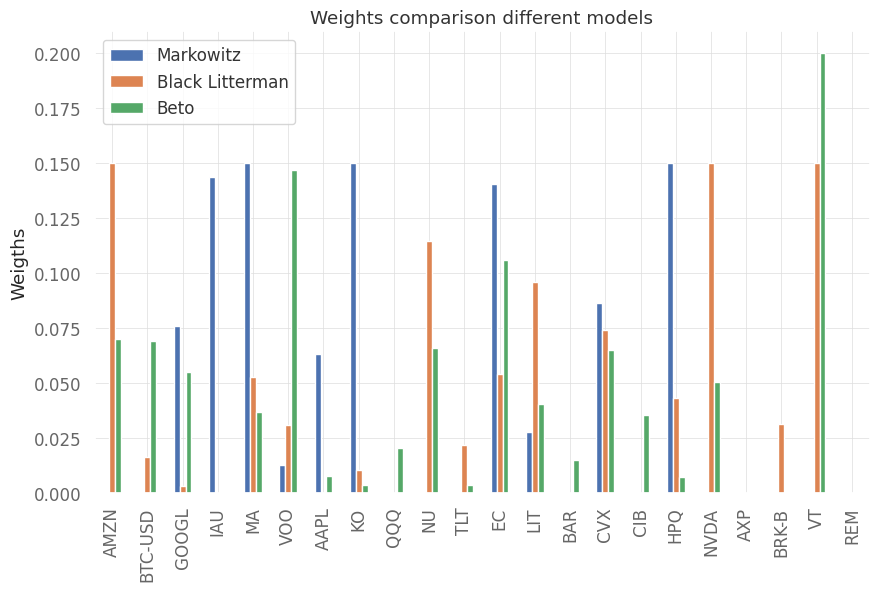

In [ ]:
df=pd.DataFrame({'Markowitz': markowitz_weights,
                'Black Litterman': BL_model_weight,
                 'Beto':beto_weights},index=assets)
df.plot(kind="bar", title='Weights comparison different models',ylabel='Weigths');

In [ ]:
df

,Markowitz,Black Litterman,Beto
AMZN,0.000000,0.15000,0.070051
BTC-USD,0.000000,0.01655,0.069128
GOOGL,0.075803,0.00319,0.055133
IAU,0.143467,0.00000,0.000000
MA,0.150000,0.05271,0.037061
VOO,0.012845,0.03122,0.146739
AAPL,0.063175,0.00000,0.007889
KO,0.150000,0.01072,0.003723
QQQ,0.000000,0.00000,0.020468
NU,0.000000,0.11442,0.066151


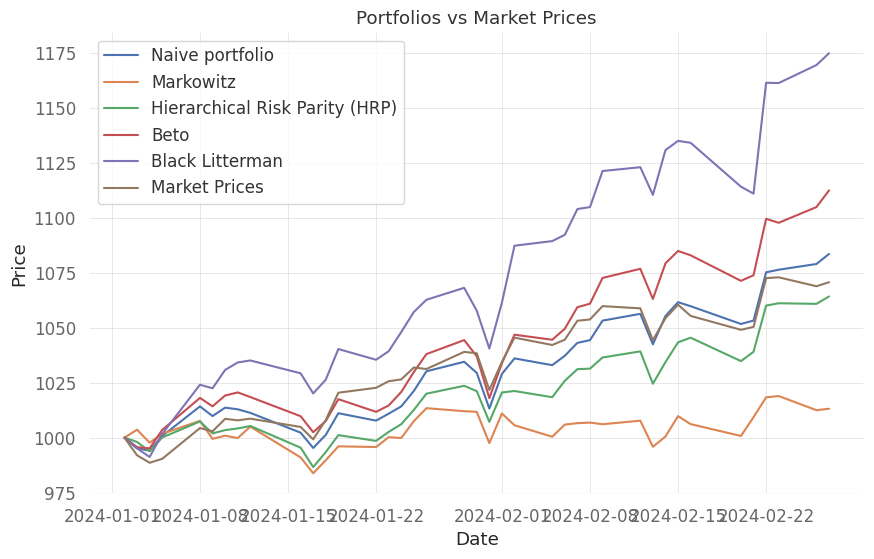

In [ ]:
# Plotting portfolio and market prices
plt.plot(naive_portfolio, label='Naive portfolio')
plt.plot(markowitz_portfolio, label='Markowitz')
plt.plot(hrp_portfolio, label='Hierarchical Risk Parity (HRP)')
plt.plot(beto_portfolio, label='Beto')
plt.plot(bl_portfolio, label='Black Litterman')
plt.plot(market_prices, label='Market Prices')

# Adding legend
plt.legend()

# Adding title
plt.title('Portfolios vs Market Prices')

# Adding axis labels
plt.xlabel('Date')
plt.ylabel('Price')


# Display the plot
plt.show()


In [ ]:
earnings = []
for a in assets:
    initial = df_prices[a][0]
    final = df_prices[a][-1]
    earning = (final - initial) / initial * 100
    earnings.append((a,initial,final, earning))

# Convert the earnings list to a DataFrame for easier manipulation and visualization
earnings_df = pd.DataFrame(earnings, columns=['Asset','Initial price','Final price', 'Earnings %'])
earnings_df=earnings_df.sort_values(by='Asset')
print(earnings_df)

      Asset  Initial price   Final price  Earnings %
6      AAPL     185.403412    182.630005   -1.495877
0      AMZN     149.929993    173.539993   15.747350
18      AXP     187.703583    217.979996   16.129907
13      BAR      20.340000     20.059999   -1.376601
19    BRK-B     362.459991    408.910004   12.815211
1   BTC-USD   44957.968750  57085.371094   26.974978
15      CIB      31.240000     32.599998    4.353389
14      CVX     147.866516    152.160004    2.903624
11       EC      11.960000     11.980000    0.167220
2     GOOGL     138.169998    138.880005    0.513865
16      HPQ      29.830000     28.830000   -3.352330
3       IAU      38.939999     38.400002   -1.386741
7        KO      59.820000     60.340000    0.869275
12      LIT      50.290001     44.250000  -12.010342
4        MA     421.226105    474.750000   12.706690
9        NU       8.130000     11.140000   37.023373
17     NVDA     481.679993    787.010010   63.388561
8       QQQ     402.589996    437.600006    8.

In [ ]:
assets = [ "AMZN", "BTC-USD","GOOGL","IAU","MA","VOO","AAPL","KO","QQQ","NU","TLT","EC","LIT","BAR","CVX","CIB","HPQ","NVDA","AXP","BRK-B","VT","REM"]

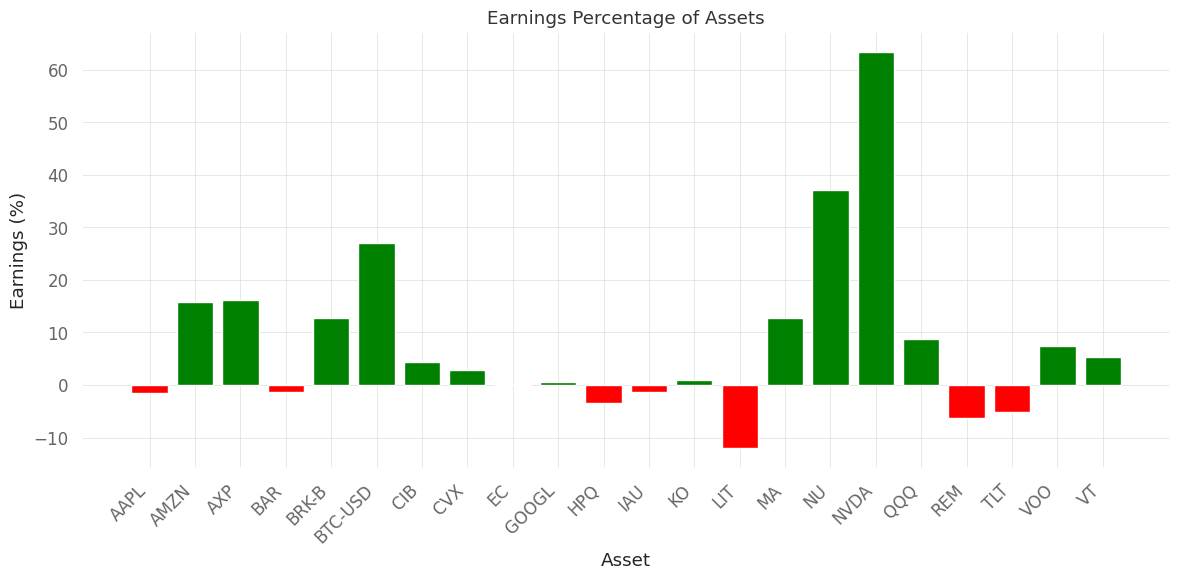

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(earnings_df['Asset'], earnings_df['Earnings %'], color=['red' if earning < 0 else 'green' for earning in earnings_df['Earnings %']])
plt.xlabel('Asset')
plt.ylabel('Earnings (%)')
plt.title('Earnings Percentage of Assets')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()